# LangGraph Quick Start

https://langchain-ai.github.io/langgraph/tutorials/introduction/

## Build a Basic Chatbot

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [8]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [10]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)

def chatbot(state: State):
    # messagesにはadd_messagesのReducerがついているため上書きではなくリストに追加される
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

In [12]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

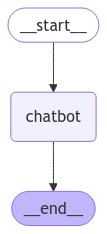

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
for event in graph.stream({"messages": [("user", "こんにちは")]}):
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: こんにちは。どうぞよろしくお願いいたします。何かお手伝いできることはありますか?


## Enhancing the Chatbot with Tools

In [36]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=5)

tools = [tool]
tool.invoke("AIエージェントとは？")

[{'url': 'https://ai-market.jp/technology/ai-agent/',
  'content': 'AIエージェントとは、 複数のAIモデルやデバイスを組み合わせることで、単一のモデルでは困難だった高度で複雑なタスクを自律的に実行 できるシステムのことを指します。. 企業がAIエージェントを活用することで、業務の自動化による大幅なコスト削減や'},
 {'url': 'https://note.com/aibootcamp/n/n8b324b14ea85',
  'content': '1. AIエージェントとは？. AIエージェントは、人工知能（AI）を利用して特定のタスクを自動的に実行するプログラムやシステムです。. 日常生活で私たちが触れる多くのAI技術は、実際にはこのAIエージェントとして機能しています。. 例えば、スマートフォン'},
 {'url': 'https://www.sbbit.jp/article/cont1/137047',
  'content': 'AIエージェントとは、複数のAIモデルを組み合わせ、単一のモデルでは困難な高度なタスクを自動で実行できるシステムのことである。. 企業の'},
 {'url': 'https://aws.amazon.com/jp/what-is/ai-agents/',
  'content': 'AI エージェントとは? 人工知能 (AI) エージェントは、環境と対話し、データを収集し、そのデータを使用して自己決定タスクを実行して、事前に決められた目標を達成するためのソフトウェアプログラムです。. 目標は人間が設定しますが、その目標を達成'},
 {'url': 'https://atmarkit.itmedia.co.jp/ait/articles/2411/06/news021.html',
  'content': '連載目次. 用語解説 AI（人工知能）分野におけるAIエージェント（AI Agent）とは、特定の目標を達成するのに必要なタスクを自律的に作成し、計画的に各タスクを実行するAIシステム（またはソフトウェアプログラム）である。人間がゴールとなる目標だけを設定すれば、AIエージェントは基本的'}]

In [51]:
llm = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

In [52]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # Toolの実行結果を追加する
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [53]:
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [55]:
def route_tools(state: State,):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [ ]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END}
)

In [57]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

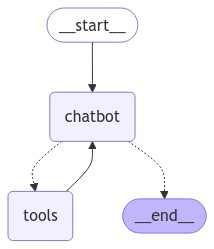

In [58]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
graph.invoke({"messages": [("user", "こんにちは")]})

{'messages': [HumanMessage(content='こんにちは', additional_kwargs={}, response_metadata={}, id='ad5df9f1-732e-4342-ac57-6f608d7f89c2'),
  AIMessage(content=[{'id': 'toolu_011gu3xv68Y271CogrimxfEv', 'input': {'query': 'こんにちは'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01X1BqfM8KmFzp1K8oEp6VdR', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 372, 'output_tokens': 62}}, id='run-119cefb3-9f38-4dba-8289-5051ecc4035e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'こんにちは'}, 'id': 'toolu_011gu3xv68Y271CogrimxfEv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 372, 'output_tokens': 62, 'total_tokens': 434, 'input_token_details': {}}),
  ToolMessage(content='[{"url": "https://en.wiktionary.org/wiki/\\u3053\\u3093\\u306b\\u3061\\u306f", "content": "For pronunciation and definitions of \\u3053\\u3093\\u306b\\u3061\\u306f - see the fo

In [60]:
graph.invoke({"messages": [("user", "私の名前は森です。")]})

{'messages': [HumanMessage(content='私の名前は森です。', additional_kwargs={}, response_metadata={}, id='fa190127-2f8e-4e7d-b893-770e7f633c9b'),
  AIMessage(content='分かりました。森さんですね。私はあなたの名前を記憶しました。これからよろしくお願いします。', additional_kwargs={}, response_metadata={'id': 'msg_01BTaykYdAnLpSexQueFTi6s', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 376, 'output_tokens': 41}}, id='run-b107a6a1-bd82-46e7-b576-271a889569d7-0', usage_metadata={'input_tokens': 376, 'output_tokens': 41, 'total_tokens': 417, 'input_token_details': {}})]}

In [61]:
graph.invoke({"messages": [("user", "LangGraphについて小学生にもわかるように教えて")]})

{'messages': [HumanMessage(content='LangGraphについて小学生にもわかるように教えて', additional_kwargs={}, response_metadata={}, id='f13ff285-5fc6-4ffd-9dbc-791484fe0562'),
  AIMessage(content=[{'id': 'toolu_01NaCNTPtiyRmGtgpjvY772Q', 'input': {'query': 'LangGraph 小学生 わかりやすい説明'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01H39huLTDz4gbmQjBhSzryr', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 384, 'output_tokens': 73}}, id='run-75351065-f02f-433b-827f-37e97c3323b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph 小学生 わかりやすい説明'}, 'id': 'toolu_01NaCNTPtiyRmGtgpjvY772Q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 384, 'output_tokens': 73, 'total_tokens': 457, 'input_token_details': {}}),
  ToolMessage(content='[{"url": "https://note.com/life_chatgpt/n/nabf4f5d96c6e", "content": "Mar 2, 2024 \\u00b7 LangGraph\\u306f\\u3001LangCha

In [64]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

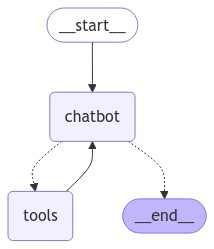

In [65]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding Memory to the Chatbot

In [66]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [80]:
from tabnanny import check
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)

In [81]:
config = {"configurable": {"thread_id": "2"}}

events = graph.stream(
    {"messages": [("user", "こんにちは。私の名前は森です。")]},
    config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

こんにちは。私の名前は森です。
================================== Ai Message ==================================

こんにちは、森さん。はじめまして。私はAIアシスタントです。何かお手伝いできることはありますか？日本語でのコミュニケーションも問題ありませんので、お気軽にお話しください。


In [82]:
events = graph.stream(
    {"messages": [("user", "私の名前がわかりますか？")]},
    config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

私の名前がわかりますか？
================================== Ai Message ==================================

はい、森さん。あなたの名前を覚えています。

先ほどのあなたの自己紹介で、「私の名前は森です」とおっしゃっていましたので、あなたのお名前が「森」さんであることを理解しています。

お名前を覚えていることをお示しできて嬉しいです。森さん、他に何かお聞きになりたいことや、お手伝いできることはありますか？


In [84]:
config = {"configurable": {"thread_id": "3"}}

events = graph.stream(
    {"messages": [("user", "私の名前がわかりますか？")]},
    config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

私の名前がわかりますか？
================================== Ai Message ==================================

申し訳ありませんが、私にはあなたの名前を知る方法がありません。私は人工知能のアシスタントで、個人情報を保持したり、過去の会話を記憶したりする機能はありません。各会話は独立しており、新しく始まるたびにリセットされます。

お名前をお聞きしてもよろしいでしょうか？そうすれば、この会話の中でお名前をお呼びすることができます。


In [87]:
config = {"configurable": {"thread_id": "2"}}
snapshot = graph.get_state(config)
print(snapshot)

StateSnapshot(values={'messages': [HumanMessage(content='こんにちは。私の名前は森です。', additional_kwargs={}, response_metadata={}, id='0ce220d2-b474-4726-bd98-e62fbd5e622f'), AIMessage(content='こんにちは、森さん。はじめまして。私はAIアシスタントです。何かお手伝いできることはありますか？日本語でのコミュニケーションも問題ありませんので、お気軽にお話しください。', additional_kwargs={}, response_metadata={'id': 'msg_014QqUH1zAzSLAPJAFamTGFL', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 411, 'output_tokens': 75}}, id='run-c3da6b69-3584-4001-9125-94c17f4e9dd5-0', usage_metadata={'input_tokens': 411, 'output_tokens': 75, 'total_tokens': 486, 'input_token_details': {}}), HumanMessage(content='私の名前がわかりますか？', additional_kwargs={}, response_metadata={}, id='9bcad099-3f44-45cf-8559-c69351a3caa8'), AIMessage(content='はい、森さん。あなたの名前を覚えています。\n\n先ほどのあなたの自己紹介で、「私の名前は森です」とおっしゃっていましたので、あなたのお名前が「森」さんであることを理解しています。\n\nお名前を覚えていることをお示しできて嬉しいです。森さん、他に何かお聞きになりたいことや、お手伝いできることはありますか？', additional_kwargs={}, response_metadata={'id': 'ms

In [89]:
snapshot.next

()

## Human-in-the-loop

In [102]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [103]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

In [104]:
user_input = "私はAIエージェントの開発方法を勉強しています。私のためにAIエージェント開発の最新トレンドについて調査をお願いできますか？"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]},
    config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

私はAIエージェントの開発方法を勉強しています。私のためにAIエージェント開発の最新トレンドについて調査をお願いできますか？
================================== Ai Message ==================================

[{'text': 'はい、もちろんAIエージェント開発の最新トレンドについて調査いたします。AIエージェント開発は急速に進化している分野ですので、最新の情報を得るために検索エンジンを使用して調査を行います。', 'type': 'text'}, {'id': 'toolu_015WbzraHVRNz86ywcTfGc1p', 'input': {'query': 'AIエージェント開発 最新トレンド 2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_015WbzraHVRNz86ywcTfGc1p)
 Call ID: toolu_015WbzraHVRNz86ywcTfGc1p
  Args:
    query: AIエージェント開発 最新トレンド 2023


In [105]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [106]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'AIエージェント開発 最新トレンド 2023'},
  'id': 'toolu_015WbzraHVRNz86ywcTfGc1p',
  'type': 'tool_call'}]

In [107]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': 'はい、もちろんAIエージェント開発の最新トレンドについて調査いたします。AIエージェント開発は急速に進化している分野ですので、最新の情報を得るために検索エンジンを使用して調査を行います。', 'type': 'text'}, {'id': 'toolu_015WbzraHVRNz86ywcTfGc1p', 'input': {'query': 'AIエージェント開発 最新トレンド 2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_015WbzraHVRNz86ywcTfGc1p)
 Call ID: toolu_015WbzraHVRNz86ywcTfGc1p
  Args:
    query: AIエージェント開発 最新トレンド 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.gartner.co.jp/ja/articles/what-s-new-in-artificial-intelligence-from-the-2023-gartner-hype-cycle", "content": "Sep 23, 2023 · 人工知能 (AI) のハイプ・サイクル：2023年」では、人工知能(AI)について、ビジネスに役立つ革新的なテクノロジをどのように特定しているのかをご紹介"}, {"url": "https://www.nikkei.com/article/DGXZQOUC065PP0W4A101C2000000/", "content": "13 hours ago · 生成AI技術の進化を追い風に、対話を実現する基盤技術であるAIエージェントの開発が進む。2024

In [110]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],
)

user_input = "LangGraphについて学習中です。これについて調べていただけますか"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [111]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================

[{'text': 'もちろん、LangGraphについて調査いたします。最新の情報を得るために、Tavily検索エンジンを使用して調べてみましょう。', 'type': 'text'}, {'id': 'toolu_017G7X6jmTf575PppsDDXfve', 'input': {'query': 'LangGraph 説明 機能 使い方'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_017G7X6jmTf575PppsDDXfve)
 Call ID: toolu_017G7X6jmTf575PppsDDXfve
  Args:
    query: LangGraph 説明 機能 使い方


In [112]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraphは、LLM（大規模言語モデル）を使用して、状態を保持できる（stateful）マルチアクターアプリケーションを構築するためのライブラリです。"
)

new_messages = [
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    AIMessage(content=answer)
]

new_messages[-1].pretty_print()

================================== Ai Message ==================================

LangGraphは、LLM（大規模言語モデル）を使用して、状態を保持できる（stateful）マルチアクターアプリケーションを構築するためのライブラリです。


In [113]:
graph.update_state(
    config,
    {"messages": new_messages}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa0ae0-94e5-6132-8002-181d2afbc553'}}

In [114]:
graph.get_state(config).next

()

In [115]:
graph.get_state(config).values["messages"]

[HumanMessage(content='LangGraphについて学習中です。これについて調べていただけますか', additional_kwargs={}, response_metadata={}, id='15dd2b64-cd75-4ed9-baf0-5fd543c24583'),
 AIMessage(content=[{'text': 'もちろん、LangGraphについて調査いたします。最新の情報を得るために、Tavily検索エンジンを使用して調べてみましょう。', 'type': 'text'}, {'id': 'toolu_017G7X6jmTf575PppsDDXfve', 'input': {'query': 'LangGraph 説明 機能 使い方'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Axcttp3dq8wTGWoJvr9vyv', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 417, 'output_tokens': 118}}, id='run-dbfd737e-436c-405d-bf35-6fc95d7ece58-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph 説明 機能 使い方'}, 'id': 'toolu_017G7X6jmTf575PppsDDXfve', 'type': 'tool_call'}], usage_metadata={'input_tokens': 417, 'output_tokens': 118, 'total_tokens': 535, 'input_token_details': {}}),
 ToolMessage(content='LangGraphは、LLM（大規模言語モデル）を使用して、状態を保

## Customizing State

In [117]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

In [ ]:
from pydantic import BaseModel

# ユーザにリクエストするためのツール
class RequestAssistance(BaseModel):
    """会話をエキスパートにエスカレーションしてください。
    これは、あなたが直接支援できない場合や、ユーザーがあなたの権限を超えるサポートを必要とする場合に使用します。
    この機能を使用する際は、エキスパートが適切なガイダンスを提供できるよう、ユーザーの「要望」を正確に伝えてください。"""
    request: str

In [120]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

In [122]:
print(llm_with_tools)

bound=ChatAnthropic(model='claude-3-5-sonnet-20240620', anthropic_api_url='https://api.anthropic.com', anthropic_api_key=SecretStr('**********'), model_kwargs={}) kwargs={'tools': [{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'input_schema': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}, {'name': 'RequestAssistance', 'description': '会話をエキスパートにエスカレーションしてください。\nこれは、あなたが直接支援できない場合や、ユーザーがあなたの権限を超えるサポートを必要とする場合に使用します。\nこの機能を使用する際は、エキスパートが適切なガイダンスを提供できるよう、ユーザーの「要望」を正確に伝えてください。', 'input_schema': {'properties': {'request': {'type': 'string'}}, 'required': ['request'], 'type': 'object'}}]} config={} config_factories=[]


In [123]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if response.tool_calls and response.tool_calls[0]["name"] == RequestAssistance.__name__:
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [124]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [125]:
from langchain_core.messages import AIMessage, ToolMessage

def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"]
    )

def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(
            create_response("人間からの返信はありません。", state["messages"][-1])
        )
    return {
        "messages": new_messages,
        "ask_human": False
    }

graph_builder.add_node("human", human_node)

In [126]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    return tools_condition(state)

In [127]:
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END}
)

In [128]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")

In [129]:
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

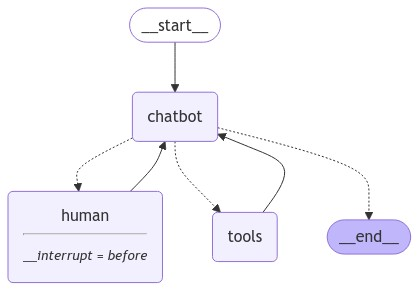

In [130]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [131]:
user_input = "このAIエージェントを作るために専門家のガイドが必要です。アドバイスを依頼できますか？"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]},
    config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

このAIエージェントを作るために専門家のガイドが必要です。アドバイスを依頼できますか？
================================== Ai Message ==================================

[{'text': 'はい、AIエージェントを作るための専門家のアドバイスを得るために、エスカレーションを行うことができます。専門家により適切なガイダンスを提供していただくため、エスカレーションリクエストを作成いたします。', 'type': 'text'}, {'id': 'toolu_01WJ5NKkNTfPXsuB9CRuXaot', 'input': {'request': 'AIエージェントの開発に関する専門家のアドバイスが必要です。特に以下の点について guidance を求めています：\n1. AIエージェントの設計と構築における重要なステップ\n2. 効果的な自然言語処理と理解のための最新の技術やアプローチ\n3. AIエージェントの倫理的な配慮と責任ある開発についてのベストプラクティス\n4. スケーラビリティとパフォーマンスの最適化のためのヒント\n5. AIエージェントのテストと評価の効果的な方法\n\nユーザーはAIエージェント開発の初期段階にあり、包括的なアドバイスを求めています。専門家の方には、上記の点を中心に、AIエージェント開発における重要な洞察や推奨事項を提供していただけますと幸いです。'}, 'name': 'RequestAssistance', 'type': 'tool_use'}]
Tool Calls:
  RequestAssistance (toolu_01WJ5NKkNTfPXsuB9CRuXaot)
 Call ID: toolu_01WJ5NKkNTfPXsuB9CRuXaot
  Args:
    request: AIエージェントの開発に関する専門家のアドバイスが必要です。特に以下の点について guidance を求めています：
1. AIエージェントの設計と構築における重要なステップ
2. 効果

In [132]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [133]:
ai_message = snapshot.values["messages"][-1]
human_response = "私たち専門家がお手伝いさせていただきます！ エージェントを構築するためにLangGraphをご検討されることをお勧めします。LangGraphは、単純な自律型エージェントと比べて、はるかに信頼性が高く拡張性に優れています。"
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa0b0c-4779-6f52-8002-112182f23cf3'}}

In [135]:
graph.get_state(config).values["messages"]

[HumanMessage(content='このAIエージェントを作るために専門家のガイドが必要です。アドバイスを依頼できますか？', additional_kwargs={}, response_metadata={}, id='13dbad09-9d86-4429-b735-848990a898f1'),
 AIMessage(content=[{'text': 'はい、AIエージェントを作るための専門家のアドバイスを得るために、エスカレーションを行うことができます。専門家により適切なガイダンスを提供していただくため、エスカレーションリクエストを作成いたします。', 'type': 'text'}, {'id': 'toolu_01WJ5NKkNTfPXsuB9CRuXaot', 'input': {'request': 'AIエージェントの開発に関する専門家のアドバイスが必要です。特に以下の点について guidance を求めています：\n1. AIエージェントの設計と構築における重要なステップ\n2. 効果的な自然言語処理と理解のための最新の技術やアプローチ\n3. AIエージェントの倫理的な配慮と責任ある開発についてのベストプラクティス\n4. スケーラビリティとパフォーマンスの最適化のためのヒント\n5. AIエージェントのテストと評価の効果的な方法\n\nユーザーはAIエージェント開発の初期段階にあり、包括的なアドバイスを求めています。専門家の方には、上記の点を中心に、AIエージェント開発における重要な洞察や推奨事項を提供していただけますと幸いです。'}, 'name': 'RequestAssistance', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_019LAQwQ5zrXygvPucJ2rwDX', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 1073, 'output_tokens': 389}}, id='run-d7e91e45-7ac6-4f6c-

In [136]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================= Tool Message =================================

私たち専門家がお手伝いさせていただきます！ エージェントを構築するためにLangGraphをご検討されることをお勧めします。LangGraphは、単純な自律型エージェントと比べて、はるかに信頼性が高く拡張性に優れています。
================================= Tool Message =================================

私たち専門家がお手伝いさせていただきます！ エージェントを構築するためにLangGraphをご検討されることをお勧めします。LangGraphは、単純な自律型エージェントと比べて、はるかに信頼性が高く拡張性に優れています。
================================== Ai Message ==================================

専門家の方からアドバイスをいただきました。AIエージェントの開発に関して、LangGraphの使用を推奨しているようです。では、この専門家の助言を元に、さらに詳しくAIエージェント開発についてお話しさせていただきます。

1. AIエージェントの設計と構築：
   - LangGraphを使用することで、より信頼性が高く拡張性に優れたAIエージェントを構築できます。
   - 設計段階では、エージェントの目的と機能を明確に定義し、それに基づいてLangGraphの構造を計画します。
   - 段階的な開発アプローチを採用し、基本機能から始めて徐々に複雑な機能を追加していくことをお勧めします。

2. 効果的な自然言語処理と理解：
   - LangGraphは最新の自然言語処理技術を活用しているため、高度な言語理解と生成が可能です。
   - 特定のドメインや用途に合わせて、適切な言語モデルを選択し、ファインチューニングすることで、より精度の高い結果が得られます。

3. 倫理的配慮と責任ある開発：
   - AIの倫理ガイドラインを開発プロセスに組み込み、公平性、透明性、プライバシー保護を確保します。
   - LangGraphを使用する際